# Using Coregionalisation for Calibration

**Example** We have three sensors, a static reference sensor (#0) a mobile sensor (#1) and another low-cost static sensor (#2). Can we use the results from the mobile sensor to allow us to make predictions at #2 in the output-space of sensor #0?

Questions and Ideas:

- Is there anything to be gained from this labourious calibration method?
- We can however colocate sensors (e.g. #0 and #2) and compute a coregionalisation matrix (which will incorporate the uncertainty). Then use this for later use when sensor #2 is in place.
- If in future other sensors are available, and we don't have access to the high-quality sensor, we can still find the coregionalisation between #2 and #3, and add to the coregionalisation matrix.


## Demo

Below we demonstrate the most simple case, as described in the example above. In this toy example there is no noise!

In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.array([[0,0,0],[1,0,0],[2,0,0],[3,0,0],[4,0,0],[0,0,1],[1,0,1],[2,1,1],[3,1,1],[0,1,2],[1,1,2],[2,1,2],[3,1,2],[4,1,2]])
Y = np.array([[2,4,6,4,2,1,2,4.5,6,1,2,3,4,5]]).T
kern = GPy.kern.RBF(2,ARD=True)**GPy.kern.Coregionalize(input_dim=1,output_dim=3, rank=1)
m = GPy.models.GPRegression(X,Y,kern)
m.kern.rbf.variance.fix(1.0)
m.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


The figure below shows the measurements taken. Five from each of the static units, and four from the mobile unit that moves between them.

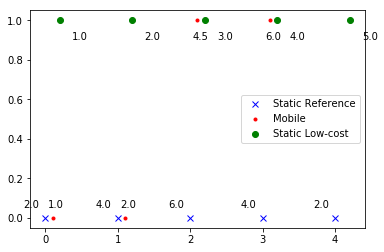

In [3]:
markers = ['xb','.r','og']
labels = ['Static Reference','Mobile','Static Low-cost']
for i in range(3):
    plt.plot(X[X[:,2]==i,0]+i/10,X[X[:,2]==i,1],markers[i],label=labels[i])
for x,y in zip(X,Y):
    plt.text(x[0]+x[2]/3-.3,x[1]*0.85+0.05,"%0.1f" % y[0])
plt.legend()

The mobile unit appears to estimate 0.5x the static reference (see along bottom of figure).
The low-cost sensor appears to estimate 0.67x the mobile sensor.

So if we measure 5 at the low-cost sensor, what would the reference sensor have measured?

Naively we can say that the mobile sensor is 1.5x the low-cost sensor (so 5x1.5=7.5) and then we can say the reference sensor is 2x this. So we would expect this point to have a static sensor value of 15:

In [4]:
m.predict(np.array([[4,1,0]]))

(array([[ 15.00000002]]), array([[  1.05629169e-07]]))

This is about 15!

We can look at the coregionalisation matrix (dividing by the coregionalisation 'variance' for the low-cost sensor), to check the above:

In [5]:
m.kern.coregion.B/m.kern.coregion.B[2,2]

array([[ 8.99999997,  4.49999997,  2.99999999],
       [ 4.49999997,  2.24999998,  1.49999999],
       [ 2.99999999,  1.49999999,  1.        ]])

The coregionalisation matrix element [1,2] is about 1.5 (actually 1.456), and if we divide element [2,3] by element [2,2] we get about 2 (actually 2.096). Thus this does as above.

There is no room for noise here, the fit assumes that sensor #2 is exactly twice #1, etc:

In [6]:
(m.kern.coregion.B/np.sqrt(np.diag(m.kern.coregion.B))).T/np.sqrt(np.diag(m.kern.coregion.B))

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

# Repeat of the above, with noise

In [7]:
sensor = np.array([1,2,2,2])
sensoroffsets = np.array([1,0.4,1.2])
sensoroffsets[sensor]

array([ 0.4,  1.2,  1.2,  1.2])

In [11]:
def get_sim_sensor(time,loc,sensor):
    sensoroffsets = np.array([0,60,10])
    sensorbias = np.array([1.0,2.0,1.5])
    sensorint = [int(x) for x in sensor]
    return sensoroffsets[sensorint][:,None]+50+sensorbias[sensorint][:,None]*(10*np.sin(time)[:,None]+25*np.cos(loc)[:,None])+2*np.random.randn(len(loc),1)

X = np.empty([0,3])
Y = np.empty([0,1])
for i in range(3):
    time = np.arange(0,4,0.5)
    loc = np.empty_like(time)
    sensor = np.full_like(time,i)
    if i==0:
        loc[:]=0
    if i==2:
        loc[:]=1
    if i==1:
        loc[0:int(len(loc)/2)] = 0
        loc[int(len(loc)/2):] = 1
    Xsensor = np.c_[time,loc,sensor]
    
    Ysensor = get_sim_sensor(time,loc,sensor)
    X = np.r_[X,Xsensor]
    Y = np.r_[Y,Ysensor]

In [13]:
kern = GPy.kern.RBF(2,ARD=True)**GPy.kern.Coregionalize(input_dim=1,output_dim=3, rank=1)
m = GPy.models.GPRegression(X,Y,kern)
m.kern.rbf.variance.fix(1.0)
m.optimize()

In [14]:
np.c_[X,Y]

array([[   0.        ,    0.        ,    0.        ,   77.47555988],
       [   0.5       ,    0.        ,    0.        ,   78.19801531],
       [   1.        ,    0.        ,    0.        ,   85.29153017],
       [   1.5       ,    0.        ,    0.        ,   81.11524611],
       [   2.        ,    0.        ,    0.        ,   84.08960461],
       [   2.5       ,    0.        ,    0.        ,   83.25646269],
       [   3.        ,    0.        ,    0.        ,   75.07827052],
       [   3.5       ,    0.        ,    0.        ,   73.49943698],
       [   0.        ,    0.        ,    1.        ,  158.10426852],
       [   0.5       ,    0.        ,    1.        ,  172.55167001],
       [   1.        ,    0.        ,    1.        ,  175.32700616],
       [   1.5       ,    0.        ,    1.        ,  176.45970291],
       [   2.        ,    1.        ,    1.        ,  155.80933572],
       [   2.5       ,    1.        ,    1.        ,  153.27715049],
       [   3.        ,    1.      

In [15]:
get_sim_sensor(np.array([3.5]),np.array([1]),np.array([0]))

array([[ 57.79040578]])

In [16]:
m.predict(np.array([[3.5,1,0]]))

(array([[ 62.04301782]]), array([[ 5.85807576]]))